[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KitchinHUB/si-dynamic-catalysis-1/blob/master/Others/13-Extended_Sabatier_Volcano.ipynb)


# Notebook #13: Extended Sabatier Volcano Analysis

This Jupyter Notebook is part of the Supporting Information for the paper *Cyclic steady state simulation and waveform design for Dynamic/Programmable Catalysis*, by C. C. Tedesco, J. R. Kitchin, and C. D. Laird.

This notebook has code to build the Sabatier Volcano and Extended Sabatier Volcano representations for the model system used in the work, with different amplitude and offset values. The system parameters and elements of the code were based on the ones by S. R. Gathamnn, M. A. Ardagh, and P. J. Dauenhauer [[1]](#1).

The Extended Sabatier Volcano is a graphical representation of the mechanisms of rate enhancement promoted by a square wave in dynamic catalysis. In this notebook, these plots are created for the systems discussed and figures shown in the paper. This code can support different systems parameters and can therefore be modified to acquire the plots and results for those. 

This notebook served as basis for obtaining the graphical scheme shown in **Figure 1**. Additionally, Extended Sabatier Volcano plots for **Figure 5a, d and g**, **Figure 6b, d and f** and **Figure 8** are obtained through this notebook. 

## Install Pyomo and IPOPT on Google Colab

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'

!pip install munch 

## Importing necessary Python libraries

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import root 
from IPython.display import Image, display

## Declaring parameter values

In [3]:
class Params:
    """
    Declares reactive system, catalyst and CSTR model parameters
    """

    def __init__(self,  T = 423.15, # K
                q = 0.0008333, # L/s
                Po = 1.01325, # bar
                Rg_constants = 0.0083144626, # kJ/K-gmol
                Rg_Caf = 0.083144626, # bar-L/K-gmol
                Rg_ODEs = 0.083144626, # bar-L/K-gmol
                kB = 1.380649e-23, # J/K
                hp = 6.62607015e-34, # J-s
                F = 96.485, # mC/gmol
                alpha = 0.6, 
                beta = 100,
                gamma = 2, 
                delta = 1.4, # eV
                H1 = 0, # kJ/mol
                H2 = 0, # kJ/mol
                N = 2.76e-6, # gmol sites
                V = 2.60e-4, # L
                Caf = 2.8423101747069843, # mol/L
                Cbf = 0, # mol/L
                Ca_starf = 0, # mol/L
                Cb_starf = 0, # mol/L
                delS1 = -135, # J/mol-K
                delS2 = 0, # J/mol-K
                delS3 = 135, # J/mol-K
                BEa0 = 0 # eV
                ):

        self.T = T # Temperature on the simulated CSTR
        self.Po = Po # Standard pressure
        self.Caf = Caf # Initial concentration of A
        self.Cbf = Cbf # Initial concentration of B
        self.Ca_starf = Ca_starf # Initial fraction of surface coverage by A
        self.Cb_starf = Cb_starf # Initial fraction of surface coverage by B
        self.Rg_constants  = Rg_constants # Gas constant used in rate constants calculation
        self.Rg_Caf = Rg_Caf # Gas constant used to calculate Caf
        self.Rg_ODEs = Rg_ODEs # Gas constant used in the ODEs
        self.kB = kB # Boltzmann constant
        self.hp = hp # Plank constant
        self.F = F  # Faraday constant, for unit conversion
        self.alpha = alpha # Parameter for the BEP relation, slope of line of the relashionship
        self.beta = beta # Parameter for the BEP relation, intercept of line of the relashionship
        self.gamma = gamma # Parameter for the BE relation, slope of line of the relashionship
        self.delta = delta # Parameter for the BE relation, common BE point
        self.H1 = H1 # Enthalpy of A
        self.H2 = H2 # Enthalpy of B
        self.V = V # Volume of the CSTR
        self.delS1 = delS1 # Entropy of A
        self.delS2 = delS2 # Entropy of reaction
        self.delS3 = delS3 # Entropy of B
        self.q = q # Volumetric rate of the reactor
        self.N = N # Number of active sites on the surface
        self.BEa0 = BEa0

## Rate constants calculation

In [4]:
def rate_constants(params):
    """
    Calculates the rate constants based on thermodynamic and kinetic calculations
    """
    
    T = params.T
    Rg_constants = params.Rg_constants
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    BEa0 = params.BEa0
    delBEa = params.delBEa
    
    # Binding energy values for A
    BEa =  BEa0 + delBEa
    
    # Binding energy values for B, from the linear relationship with Bea   
    BEb = gamma * BEa + H2 / F - gamma * H1 / F + (1 - gamma) * delta

    # Heat of reaction (kJ/mol)
    delH1 = -BEa * F # For the adsorption step
    delH2 = (H2 - BEb * F) - (H1 - BEa * F) # For the surface reaction step
    delH3 = BEb * F # For the desorption step

    # Activation energy from BEP relationship (kJ/mol)
    Ea = alpha * delH2 + beta

    # Gibbs free energy  
    delG1 = delH1 - T * delS1 * 0.001 # For the adsorption step
    delG2 = delH2 - T * delS2 * 0.001 # For the surface reaction step
    delG3 = delH3 - T * delS3 * 0.001 # For the desorption step

    # Equilibrium constants (unitless)
    K1 = np.exp(-delG1 / Rg_constants / T) # For the adsorption step
    K2 = np.exp(-delG2 / Rg_constants / T) # For the surface reaction step 
    K3 = np.exp(-delG3 / Rg_constants / T) # For the desorption step

    # Rate constants (1/s)
    kf1 = ((kB * T) / hp) * np.exp(delS1 * 0.001 / Rg_constants) # For the adsorption of A
    kf2 = ((kB * T) / hp) * np.exp(-Ea / Rg_constants / T) # For the forward surface reaction
    kr3 = ((kB * T) / hp)*np.exp(-delS3 * 0.001 / Rg_constants) # For the adsorption of B
    kr1 = kf1 / K1 # For the desorption of A
    kr2 = kf2 / K2 # For the reverse surface reaction
    kf3 = kr3 * K3 # For the desorption of B

    return [kf1, kf2, kf3, kr1, kr2, kr3, BEa]

## Declaring the differential algebraic system of equations

In [5]:
def DAE_system(t,x):
    """
    Calculates the rate constants based on thermodynamic and kinetic calculations
    """
    
    Ca = x[0]
    Cb = x[1]
    thetaA = x[2]
    thetaB = x[3]
    
    T = params.T
    q = params.q
    Po = params.Po
    Caf = params.Caf
    Cbf = params.Cbf
    Ca_starf = params.Ca_starf
    Cb_starf = params.Cb_starf
    Rg_constants = params.Rg_constants
    Rg_Caf = params.Rg_Caf
    Rg_ODEs = params.Rg_ODEs
    N = params.N
    V = params.V

    # Site balance
    theta_star = 1 - thetaA - thetaB
    
    kf1, kf2, kf3, kr1, kr2, kr3, BEa = rate_constants(params)

    # ODEs
    dCadt = (q / V) * (Caf - Ca) - kf1 * Ca * Rg_ODEs * T * (theta_star) / Po * (N / V) + kr1 * thetaA * (N / V)
    dCbdt = (q / V) * (Cbf - Cb) + (kf3 * thetaB - kr3 * Cb * Rg_ODEs * T * (theta_star) / Po) * (N / V)
    dthetaAdt = kf1 * Ca * Rg_ODEs * T * (theta_star) / Po - kr1 * thetaA - kf2 * thetaA + kr2 * thetaB
    dthetaBdt = (kf2 * thetaA - kr2 * thetaB) - (kf3 * thetaB - kr3 * Cb * Rg_ODEs * T * (theta_star) / Po)

    return ([dCadt, dCbdt, dthetaAdt, dthetaBdt])

In [6]:
params = Params()

## Building the Sabatier Volcano

In [7]:
def volcano(params):  
    """
    Simulates TOF results for a range of binding energy values to build the Sabatier Volcano for the system
    """
    
    # Establiching values for binding energy options
    UL = 0.5
    UR = 2.2
    interval = 0.0005
    ise = UL / interval
    ie = UR / interval

    BE_var = np.linspace(1,(ie - ise + 1), 400)

    BEas = []
    TOFs = []
    kf2s = []
    kf3s = []

    # For each value in the BEa values linspace, calculate the TOF by simulating using solve_ivp
    for i in BE_var:

        params.delBEa = interval * (i - 1 + ise)

        kf1, kf2, kf3, kr1, kr2, kr3, BEa = rate_constants(params)

        T = params.T
        q = params.q
        Po = params.Po
        Caf = params.Caf
        Cbf = params.Cbf
        Ca_starf = params.Ca_starf
        Cb_starf = params.Cb_starf
        Rg_constants = params.Rg_constants
        Rg_Caf = params.Rg_Caf
        Rg_ODEs = params.Rg_ODEs
        N = params.N
        V = params.V

        tspan = np.array([0, 10])
        t_eval, h = np.linspace(*tspan, 100, retstep = True)
        y0 = np.array([Caf, Cbf, Ca_starf, Cb_starf])

        tol = 1e-8

        # Identifying steady state in order to plot each point on the volcano
        success = False
        for i in range(100):
            sol = solve_ivp(fun = DAE_system, t_span = tspan, y0 = y0, method='Radau', max_step=h)
            # Now, check variance in the solution
            # get the standard deviation between results to check for steady state
            sd = np.std(sol.y, axis=1)

            if np.all(sd < tol): # if all values of standard deviation are less than the tolerance,
                success = True # we now consider the success is true. 
                # Calculate TOF from the last value of Cb, being in steady state (Cb * q / N)
                TOF = (sol.y[1][-1]*q/N)
                
                TOFs.append(TOF)
                BEas.append(BEa)  
                kf2s.append(kf2)
                kf3s.append(kf3)
                
                break 
            else:
                # Update tspan and initial condition
                tspan = (sol.t[-1], sol.t[-1] + (tspan[1] - tspan[0])) 
                y0 = sol.y[:, -1] # Initial condition will be the last point of concentrations found

    return [BEas, TOFs]

In [8]:
BEas, TOFs = volcano(params)

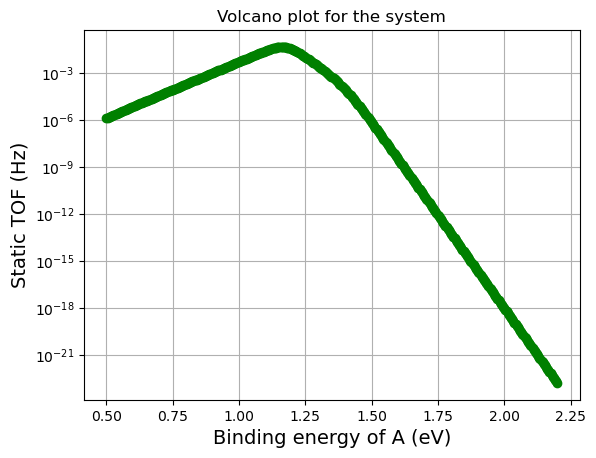

In [9]:
# To plot solely the volcano 

plt.semilogy(BEas, TOFs, 'o-', color= 'green')
plt.xlabel('Binding energy of A (eV)', fontsize=14)

plt.ylabel('Static TOF (Hz)', fontsize=14)
plt.title('Volcano plot for the system')
plt.grid()
plt.savefig('opt_square.png', dpi=500);

## Building the Extended Sabatier Volcano on top of the regular Volcano

In [10]:
def lines_over_volcano(BEas, TOFs): 
    """
    Builds the lines that extend from the Volcano's both sides
    """
    
    # LHS LINE (red)

    # Get points to fit a line - arbitrary, but in the very LHS bottom of the volcano
    BEas_line = BEas[75:85]
    TOFs_line = TOFs[75:85]

    # Take the logarithm of TOFs - otherwise it does not look like a line
    log_TOF = np.log10(TOFs_line)

    # Fit a line between the values - this is a line in the 10 points
    slope_and_offset = np.polyfit(BEas_line, log_TOF, 1)

    # Create a linear function from the coefficients which are the slope and offset of the line fitted
    line = np.poly1d(slope_and_offset)

    # Array for plotting the extrapolated line
    BEa_line = np.linspace(BEas[0], BEas[399], 100000)

    # Apply the line equation in the BEa points to get the TOF values for the line
    TOF_line = line(BEa_line) 

    # Transform back the values from log space to be able to plot
    TOF_fit = 10 ** TOF_line

    # ------------------------------------------------------------------- #

    # RHS LINE (blue)

    # Will get the last point now - arbitrary again, but in the very RHS bottom of the volcano
    BEas_line_RHS = BEas[-30:-40:-1]
    TOFs_line_RHS = TOFs[-30:-40:-1]

    # Take the logarithm of TOFs
    log_TOF_RHS = np.log10(TOFs_line_RHS)

    # Fit a line between the values
    slope_offset_RHS = np.polyfit(BEas_line_RHS, log_TOF_RHS, 1)

    # Create a linear function from the coefficients which are the slope anf offset
    line_RHS = np.poly1d(slope_offset_RHS)

    # Invert order to plot from last point to first BEa point on the plot
    BEa_line_RHS = np.linspace(BEas[399], BEas[10], 100000)

    # Apply the line equation in the BEa points to get the TOF values for the line
    TOF_line_RHS = line_RHS(BEa_line_RHS) 

    # Crucial: transform back the values from log space to be able to plot
    TOF_fit_RHS = 10 ** TOF_line_RHS

    return [BEa_line, TOF_fit, BEa_line_RHS, TOF_fit_RHS, slope_and_offset, slope_offset_RHS, line, line_RHS]

In [11]:
def plot_offset_line(amplitude, offset):
    """
    Marks the BE values calculated from amplitude and offset and builds the exponential function between points
    """
    
    # For the square wave, values for strong and weak binding energies
    BE_weak = amplitude * (-1) + offset
    BE_strong = amplitude * (1) + offset
    
    BEa_line, TOF_fit, BEa_line_RHS, TOF_fit_RHS, slope_and_offset, slope_offset_RHS, line, line_RHS = lines_over_volcano(BEas, TOFs)
    
    weak_BE_point = BE_weak
    weak_TOF_point = line_RHS(BE_weak)
    strong_BE_point = BE_strong
    strong_TOF_point = line(BE_strong)
        
    # Plotting the line between the BE points
    # Line from (X1, Y1) to (X2, Y2): (X1+dX, Y1 + m *dX)
    # Linspace of interval points between BE values
    dX = np.linspace(0, strong_BE_point - weak_BE_point, 100)
    
    # Slope and intercept based on log values 
    slope = ((strong_TOF_point) - (weak_TOF_point))/(strong_BE_point - weak_BE_point) # m = (y2 - y1)/(x1 - x2)
    y_intercept = (weak_TOF_point)
    
    # Transform it back so it is a line when in the semilog space
    y_offset_line =  10 ** (slope * dX + y_intercept) # y = 10 ** (ax + b)
    
    return [weak_BE_point, weak_TOF_point, strong_BE_point, strong_TOF_point, y_offset_line, slope]

## Obtaining the plots for different amplitude/offset systems

### Systems with rate constant ratios of 0.1, 1, and 10 (Unidimensional optimization, **Figure 5a, d and g**)

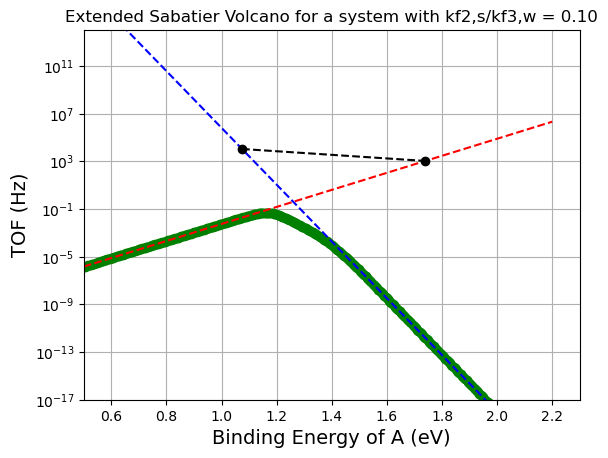

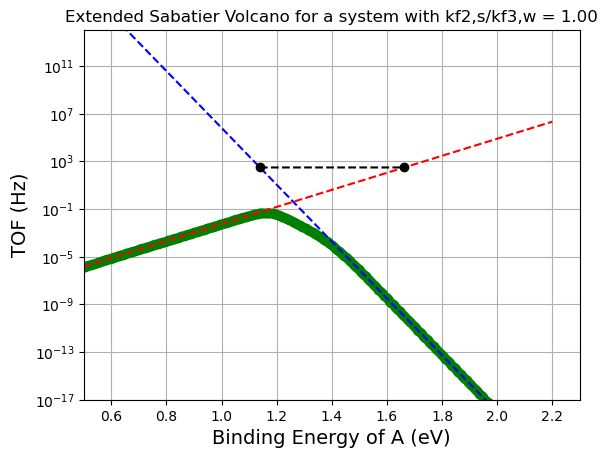

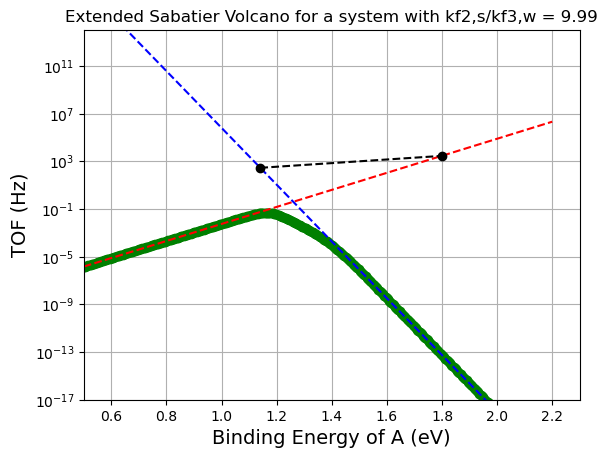

In [12]:
amplitudes = [0.3326087, 0.26186186, 0.32912913]

offsets =  [1.40685619, 1.4012012, 1.46966967]

for amplitude, offset in zip(amplitudes, offsets):

    BEa_line, TOF_fit, BEa_line_RHS, TOF_fit_RHS, slope_and_offset, slope_offset_RHS, _, _ = lines_over_volcano(BEas, TOFs)

    weak_BE_point, weak_TOF_point, strong_BE_point, strong_TOF_point, y_offset_line, slope = plot_offset_line(amplitude, offset)

    params.delBEa = weak_BE_point
    _, _, kf3w, _, _, _, _ = rate_constants(params)

    params.delBEa = strong_BE_point
    _, kf2s, _, _, _, _, _ = rate_constants(params)

    ratio = kf2s / kf3w

    # Plotting the volcano
    plt.plot(BEas, TOFs, 'go')
    plt.plot(BEa_line, TOF_fit, 'r--')
    plt.plot(BEa_line_RHS, TOF_fit_RHS, 'b--')

    # Plotting the offset point and line
    plt.plot(weak_BE_point, 10 ** weak_TOF_point, 'o', color='k')
    plt.plot(strong_BE_point, 10 ** strong_TOF_point, 'o',  color='k')

    # Plotting the offset line between BE values
    x_values = np.linspace(weak_BE_point, strong_BE_point, 100)
    plt.plot(x_values, y_offset_line, 'k--')

    plt.xlabel('Binding Energy of A (eV)', fontsize=14)
    plt.ylabel('TOF (Hz)', fontsize=14)
    plt.grid()
    plt.xlim(0.5, 2.3)
    plt.ylim(1e-17,1e14)
    plt.yscale('log')
    plt.title(f'Extended Sabatier Volcano for a system with kf2,s/kf3,w = {ratio:1.2f}')
    plt.show();

### Systems with optimal offset (bidimensional optimization, **Figure 6b, d and f**)

Acquisition of optimal offset values is shown in Notebook #15.

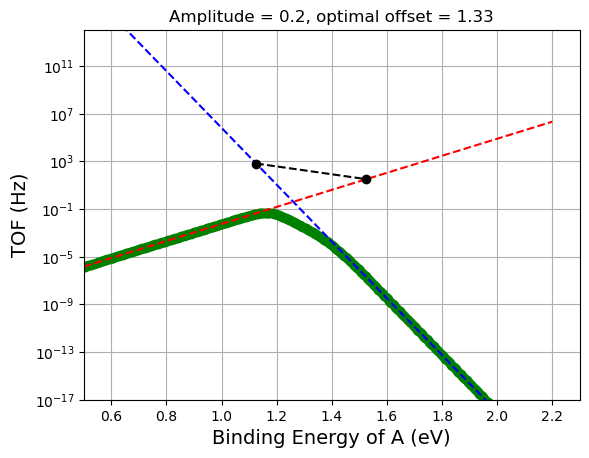

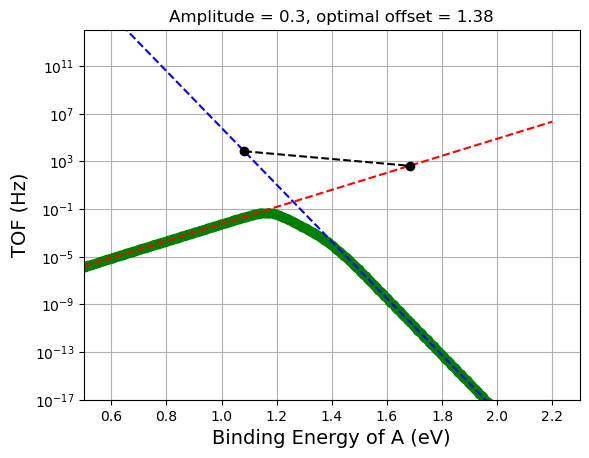

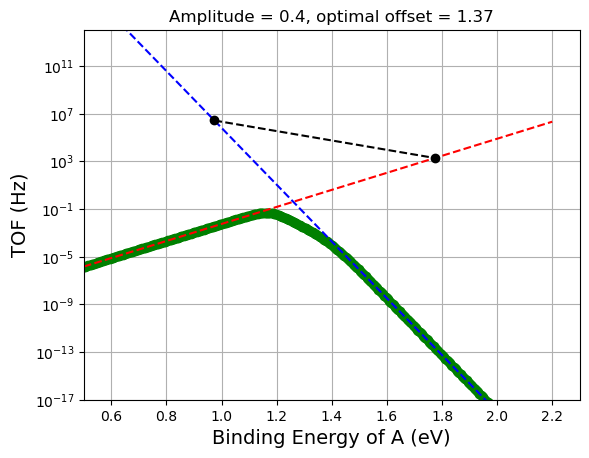

In [16]:
amplitudes = [0.2, 0.3, 0.4]
offsets =  [1.325383988672355, 1.382261617838889, 1.373938913979817]

for i, (amplitude, offset) in enumerate(zip(amplitudes, offsets)):
    
    BEa_line, TOF_fit, BEa_line_RHS, TOF_fit_RHS, slope_and_offset, slope_offset_RHS, _, _ = lines_over_volcano(BEas, TOFs)

    weak_BE_point, weak_TOF_point, strong_BE_point, strong_TOF_point, y_offset_line, slope = plot_offset_line(amplitude, offset)

    # Plotting the volcano
    plt.plot(BEas, TOFs, 'go')
    plt.plot(BEa_line, TOF_fit, 'r--')
    plt.plot(BEa_line_RHS, TOF_fit_RHS, 'b--')

    # Plotting the offset point and line
    plt.plot(weak_BE_point, 10 ** weak_TOF_point, 'o', color='k')
    plt.plot(strong_BE_point, 10 ** strong_TOF_point, 'o',  color='k')

    # Plotting the offset line between BE values
    x_values = np.linspace(weak_BE_point, strong_BE_point, 100)
    plt.plot(x_values, y_offset_line, 'k--')

    plt.xlabel('Binding Energy of A (eV)', fontsize=14)
    plt.ylabel('TOF (Hz)', fontsize=14)
    plt.grid()
    plt.xlim(0.5, 2.3)
    plt.ylim(1e-17,1e14)
    plt.yscale('log')
    plt.title(f'Amplitude = {amplitude}, optimal offset = {offset:1.2f}')
    plt.show();

### Example systems (Optimum, flat offset line, extreme optimal duty cycle, Figure 8)

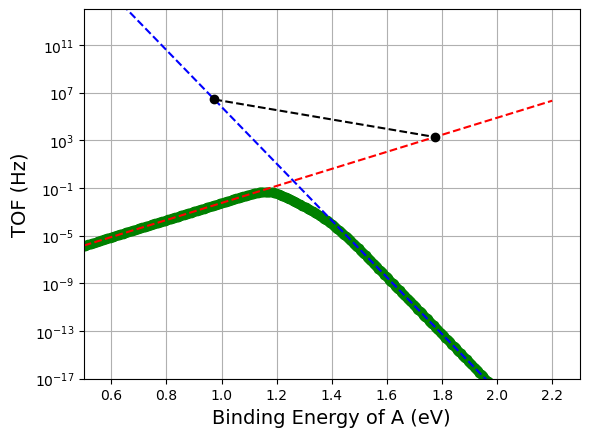

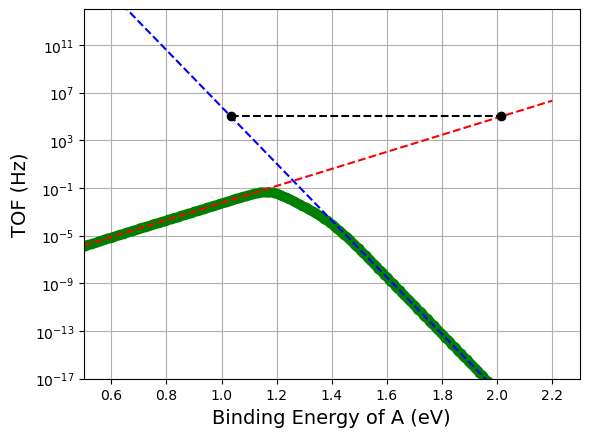

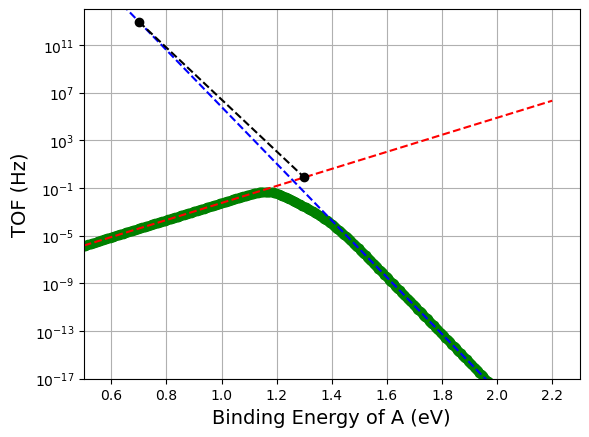

In [14]:
amplitudes = [0.4, 0.4909817552962199, 0.3]
offsets =  [1.3739385627527776, 1.5245355541221275, 1]

for i, (amplitude, offset) in enumerate(zip(amplitudes, offsets)):
    
    BEa_line, TOF_fit, BEa_line_RHS, TOF_fit_RHS, slope_and_offset, slope_offset_RHS, _, _ = lines_over_volcano(BEas, TOFs)

    weak_BE_point, weak_TOF_point, strong_BE_point, strong_TOF_point, y_offset_line, slope = plot_offset_line(amplitude, offset)

    # Plotting the volcano
    plt.plot(BEas, TOFs, 'go')
    #fig, ax = plt.subplots()
    plt.plot(BEa_line, TOF_fit, 'r--')
    plt.plot(BEa_line_RHS, TOF_fit_RHS, 'b--')

    # Plotting the offset point and line
    plt.plot(weak_BE_point, 10**weak_TOF_point, 'o', color='k')
    plt.plot(strong_BE_point, 10**strong_TOF_point, 'o',  color='k')

    # Plotting the offset line between BE values
    x_values = np.linspace(weak_BE_point, strong_BE_point, 100)
    plt.plot(x_values, y_offset_line, 'k--')

    plt.xlabel('Binding Energy of A (eV)', fontsize=14)
    plt.ylabel('TOF (Hz)', fontsize=14)
    plt.grid()
    plt.xlim(0.5, 2.3)
    plt.ylim(1e-17,1e14)
    plt.yscale('log')
    plt.show();

## Getting TOF values to calculate Enhancement Factors in Notebook #1

In [15]:
# Optimal amplitude and offset values for the square wave
amplitude = 0.4 # eV
offset = 1.37 # eV

weak_BE_point, weak_TOF_point, strong_BE_point, strong_TOF_point, y_offset_line, slope = plot_offset_line(amplitude, offset)

BEas = np.array(BEas)
TOFs = np.array(TOFs)

TOF_weak_BE_point = TOFs[np.abs(BEas - weak_BE_point).argmin()]
TOF_strong_BE_point = TOFs[np.abs(BEas - strong_BE_point).argmin()]

TOF_Sabatier_peak = np.max(TOFs)

print(f'TOF on Sabatier Peak is {TOF_Sabatier_peak:1.2f} 1/s and TOF in strong and weak point are respectively \
{TOF_strong_BE_point:1.2e} and {TOF_weak_BE_point:1.2e} 1/s.')

TOF on Sabatier Peak is 0.05 1/s and TOF in strong and weak point are respectively 2.92e-13 and 3.30e-03 1/s.


## Bibliography

<a id="1">1. S. R. Gathmann, M. A. Ardagh, and P. J. Dauenhauer. Catalytic resonance theory: Negative
dynamic surfaces for programmable catalysts. Retrieved from the Data Repository for the
University of Minnesota, 2021.